# 将模型预测的参数值可视化出来

## 导入所有信息

### 导入依赖

In [1]:
import json
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
sys.path.append(os.getenv("PROJ_PATH"))  # type: ignore

from dmg.core.post.plot_parameters import plot_parameters,plot_parameter_distributions  # noqa
from project.better_estimate import load_config  # noqa

### 导入配置

In [2]:
config = load_config(r"conf/config_dhbv_hopev4.yaml")
out_path = config["out_path"]

### 加载数据

In [3]:
from dmg.core.data.loaders import HydroLoader   # noqa

loader = HydroLoader(config, test_split=True, overwrite=False)
loader.load_dataset()
eval_dataset = loader.eval_dataset

### 加载流域ids

In [4]:
with open(os.path.join(os.getenv("DATA_PATH"), "531sub_id.txt"), "r") as f:
    selected_basins = np.array(json.load(f))

## 构建模型

In [17]:
from dmg import ModelHandler
from dmg.core.utils import import_trainer  # noqa
import torch.nn.functional as F  # noqa
import torch  # noqa

config["mode"] = "test"
config["test"]["test_epoch"] = 80
model = ModelHandler(config, verbose=True)
trainer_cls = import_trainer(config["trainer"])
trainer = trainer_cls(
    config,
    model,
    eval_dataset=eval_dataset,
    verbose=True,
)
nn_model = trainer.model.model_dict["Hbv_2"].nn_model

## 得到模型输出结果

select basin: 200
torch.Size([1460, 3, 16])


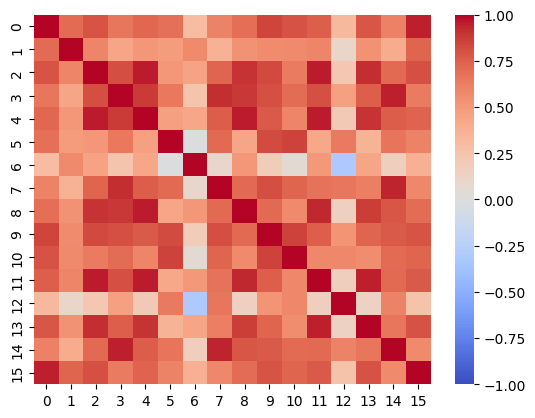

In [18]:
import torch

model_input = eval_dataset["xc_nn_norm"]
# select_basin_idx = np.where(selected_basins==1031500)[0][0]
select_basin_idx = 200
# select_basin_idx = 0
print(f"select basin: {select_basin_idx}")
tmp_model_input = model_input[0:730*2, select_basin_idx : select_basin_idx + 1, :]
layer_output = nn_model.predict_timevar_parameters(tmp_model_input)
layer_output = layer_output.reshape(-1, 3, 16)
print(layer_output.shape)
corr_matrix = np.corrcoef(layer_output.detach().cpu().numpy()[:,0,:], rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# 绘制相关性热图
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

## 绘制模型预测结果

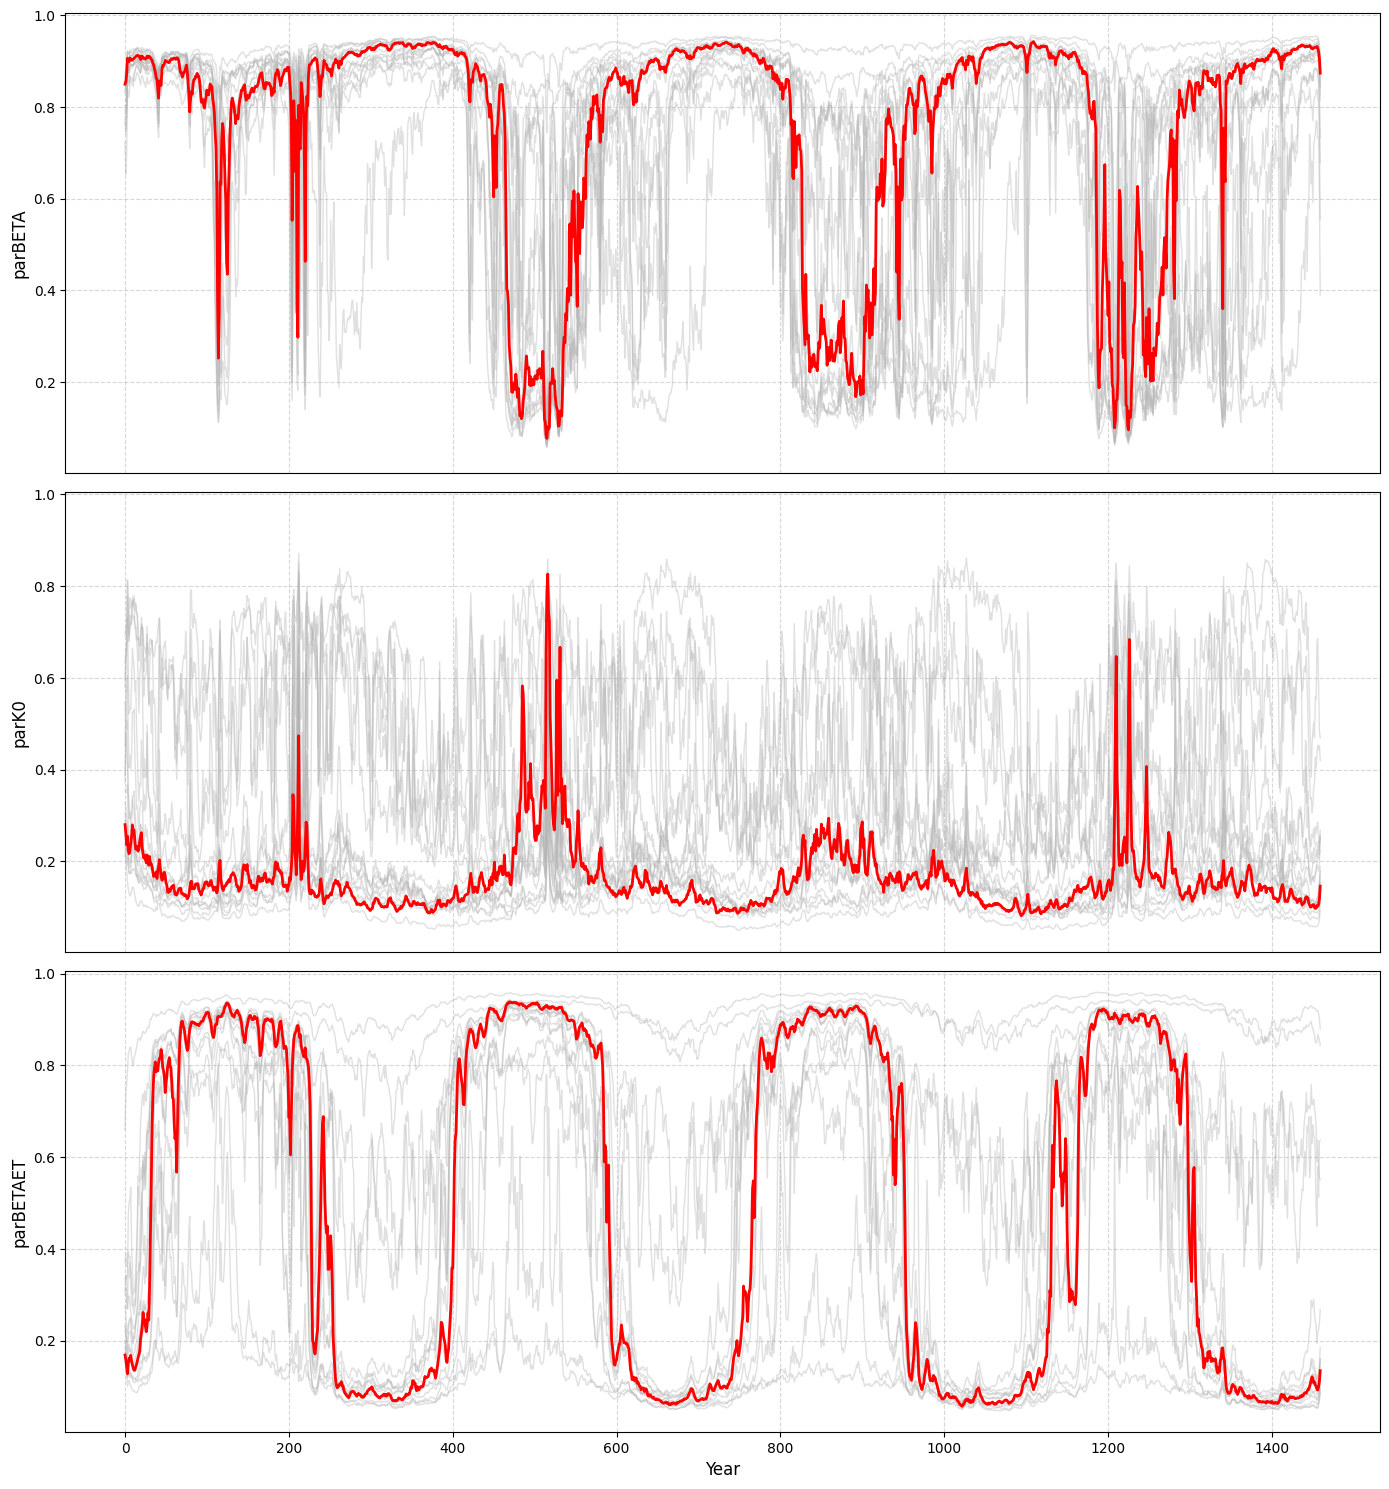

In [21]:
timevar_params = layer_output.detach().cpu().numpy()
titles = ['parBETA', 'parK0', 'parBETAET']
plot_parameters(timevar_params, titles=titles, median_color='red',smooth_method='moving_average', window=1)
plt.show()

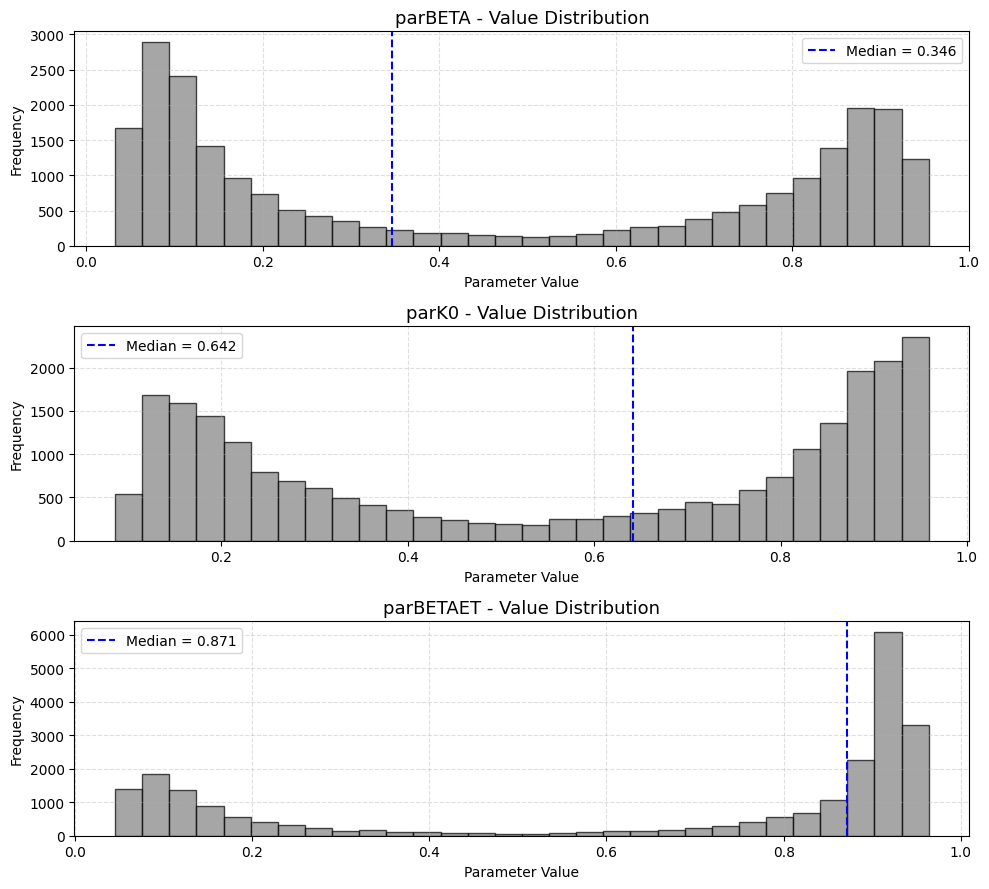

In [8]:
plot_parameter_distributions(timevar_params, titles=titles)
plt.show()